In [1]:
from models.yolo import Model
from pathlib import Path
import torch
import torch.nn.functional as F

from utils.torch_utils import intersect_dicts

In [2]:
import torch
import torch.utils.data
import torch.cuda
import torch.optim
import torch.nn
from torchvision import datasets, transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

def imshow(imgs, label=""):
    imgs = vutils.make_grid(imgs, normalize=True)
    fig, ax = plt.subplots(1, squeeze=False, frameon=False, dpi=300)
    ax[0][0].imshow(np.transpose(imgs.cpu().detach().numpy(), (1, 2, 0)), interpolation="nearest")  # type: ignore
    ax[0][0].axis("off")  # type: ignore
    ax[0][0].set_title(label)  # type: ignore
    fig.show()  # type: ignore


def check_mem():
    return torch.cuda.memory_allocated() / 1024 / 1024 / 1024


In [3]:
device = torch.device("cuda")

weights_path = Path.cwd() / "runs/exp17_yolov4-csp-results/weights/best_yolov4-csp-results.pt"
ckpt = torch.load(weights_path, map_location=device)
detection_model = Model(ckpt["model"].yaml, ch=3, nc=1).to(device)
state_dict = ckpt["model"].float().state_dict()
state_dict = intersect_dicts(state_dict, detection_model.state_dict())  # intersect
detection_model.load_state_dict(state_dict, strict=False)  # load
detection_model.eval()


                 from  n    params  module                                  arguments                     
  0                -1  1       928  models.common.Conv                      [3, 32, 3, 1]                 
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     20672  models.common.Bottleneck                [64, 64]                      
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  1    119936  models.common.BottleneckCSP             [128, 128, 2]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  1   1463552  models.common.BottleneckCSP             [256, 256, 8]                 
  7                -1  1   1180672  models.common.Conv                      [256, 512, 3, 2]              
  8                -1  1   5843456  

Model(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): MishCuda()
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): MishCuda()
    )
    (2): Bottleneck(
      (cv1): Conv(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): MishCuda()
      )
      (cv2): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): MishCuda()
      )
    )
    (3): Conv(
 

In [4]:
from torchvision import transforms
import numpy as np

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

img_size = 416

mean, std = np.array(mean, dtype=float), np.array(std, dtype=float)

to_tensor = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize(mean, std)
])

# inv_norm = transforms.Compose([
#     transforms.Normalize(np.zeros(3), 1/std),
#     transforms.Normalize(-mean, np.ones(3))
# ])

to_pil = transforms.Compose([
#     inv_norm,
    transforms.Lambda(lambda img: torch.clamp(img, 0, 1)),
    transforms.ToPILImage()
])

In [5]:
from functools import lru_cache
from torchvision import datasets, transforms

datadir = Path('../../data')

@lru_cache(maxsize=10)
def dataset(img_size, split="train"):
    return datasets.ImageNet(root=str(datadir), split=split, transform=transforms.Compose([
            transforms.RandomResizedCrop(img_size, scale=(0.9, 1.0), ratio=(1., 1.)),
            to_tensor
        ]))

def subset(imageset, size):
    res, _ = torch.utils.data.random_split(imageset, [size, len(imageset) - size])
    return res

def dataloader(imageset, batch_size):
    return torch.utils.data.DataLoader(imageset, batch_size=batch_size, shuffle=True)

In [6]:
from utils.general import non_max_suppression, plot_images, output_to_target

conf_thres=0.5
iou_thres=0.6
merge=False

def to_size(imgs, size=244):
    return F.interpolate(imgs, size=size)

def clear_data(data, plot_name=None):
    x = to_size(data, 416).to(device)
    with torch.no_grad():
        inf_out, train_out = detection_model(x.to(device))
    output = non_max_suppression(inf_out, conf_thres=conf_thres, iou_thres=iou_thres, merge=merge)
    if plot_name is not None:
        plot_images(data.detach().cpu().numpy(), output_to_target(output, 416, 416), fname=plot_name)
    
    
    mask = torch.zeros_like(x).mean(1).to(torch.bool).to(device)

    for ind, result in enumerate(output):
        if result is not None:
            for p in result:
                x1, y1, x2, y2, conf, cl = p.cpu().numpy()
                Y, X = np.ogrid[:x.shape[-2], :x.shape[-1]]
                m = (X>=x1) & (X<x2) & (Y>=y1) & (Y<y2)
                mask[ind] = mask[ind] | torch.tensor(m).to(device)

    mask = mask.to(torch.float).unsqueeze(1)
    
    cleared = x.mean([-1,-2]).unsqueeze(-1).unsqueeze(-1) * mask + x * (1-mask)
    return cleared

In [10]:
from patch_maker import PatchMaker
from torchvision import models

model = models.resnet101(pretrained=True)
model.eval()
for param in model.parameters():
    param.requires_grad = False
model = model.to(device)

pm_test = PatchMaker(device=device)
pm_test.set_transforms(rotate_angle=(-180, 180), shear=(0, 0), size_by_im=(0.3, 0.4))

patches_folder = Path.cwd().parent / "Patches" / "test"
patches = list(patches_folder.iterdir())

In [11]:
patches = [Path.cwd().parent / "Patches" / "859_toaster.png"]

In [9]:
mean_tensor=torch.tensor([0.485, 0.456, 0.406]).to(device).reshape(1,3,1,1)
std_tensor=torch.tensor([0.229, 0.224, 0.225]).to(device).reshape(1,3,1,1)

def normalize_imagenet(imgs):
    return (imgs.to(device) - mean_tensor) / std_tensor

In [23]:
from tqdm.auto import tqdm
import random

def test(model, img_size=244, batch_size=10, test_size=100000):
    scores = {
        "plain": 0,
        "with_patch": 0,
        "patch_succeed": 0,
        "with_patch_protection": 0,
        "plain_protection": 0,
        "patch_protection_succeed": 0
    }
    
    dl = dataloader(subset(dataset(img_size, "val"), test_size), batch_size)
    num_tested = 0
    
    for data, labels in tqdm(dl, leave=False):
        try:
            data = data.to(device)
            labels = labels.to(device)

            patch_path = random.choice(patches)
            target = int(patch_path.name.split("_")[0])
            
            data = data[labels != target]
            labels = labels[labels != target]
            num_tested += len(labels)
            
            patch = to_tensor(Image.open(patch_path))
            pm_test.set_patch(patch)
            patched_data = pm_test.random_patch_place(data)

            _, preds = model(normalize_imagenet(data)).max(1)
            scores["plain"] += (labels == preds).float().sum().item()

            _, preds = model(normalize_imagenet(patched_data)).max(1)
            scores["with_patch"] += (labels == preds).float().sum().item()
            scores["patch_succeed"] += (preds == (torch.ones_like(labels) * target)).float().sum().item()

            data = to_size(clear_data(data), img_size)
            _, preds = model(normalize_imagenet(data)).max(1)
            scores["plain_protection"] += (labels == preds).float().sum().item()

            patched_data = to_size(clear_data(patched_data), img_size)
            _, preds = model(normalize_imagenet(patched_data)).max(1)
            scores["with_patch_protection"] += (labels == preds).float().sum().item()
            scores["patch_protection_succeed"] += (preds == (torch.ones_like(labels) * target)).float().sum().item()
        except KeyboardInterrupt:
            break
    return {
        k: v / num_tested for k, v in scores.items()
    }

In [26]:
test(model, test_size=100000)

{'plain': 0.7737737737737738,
 'with_patch': 0.23145145145145146,
 'patch_succeed': 0.6197797797797798,
 'with_patch_protection': 0.6343543543543544,
 'plain_protection': 0.7665665665665665,
 'patch_protection_succeed': 0.0003203203203203203}

In [13]:
dl = dataloader(subset(dataset(244), 8), 4)

In [14]:
it = iter(dl)
data, labels = next(it)

In [15]:
data = data.to(device)
labels = labels.to(device)

patch_path = random.choice(patches)
target = int(patch_path.name.split("_")[0])
patch = to_tensor(Image.open(patch_path))
pm_test.set_patch(patch)
patched_data = pm_test.random_patch_place(data)
cleared_data = to_size(clear_data(patched_data, "test.jpg"), img_size)

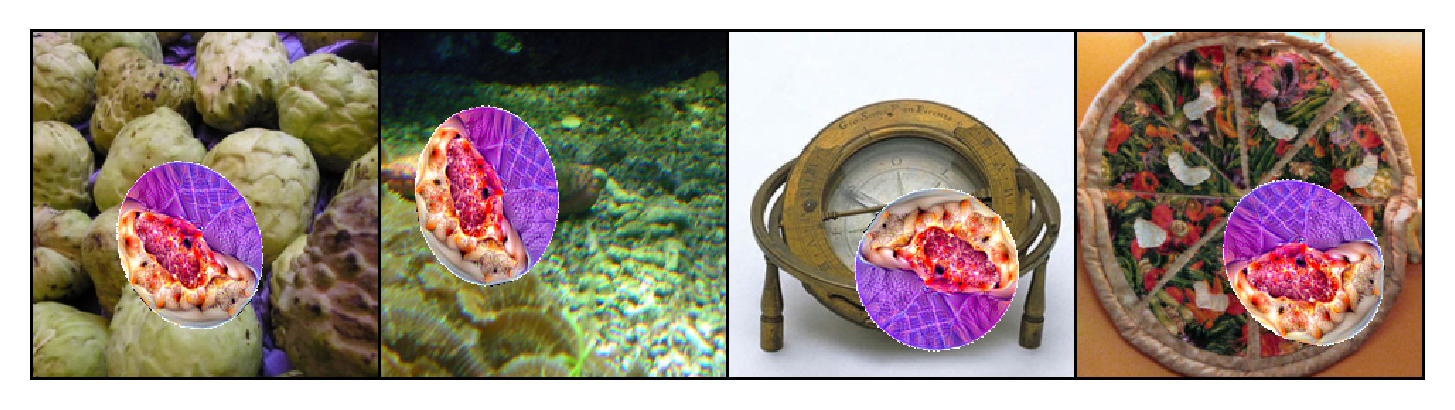

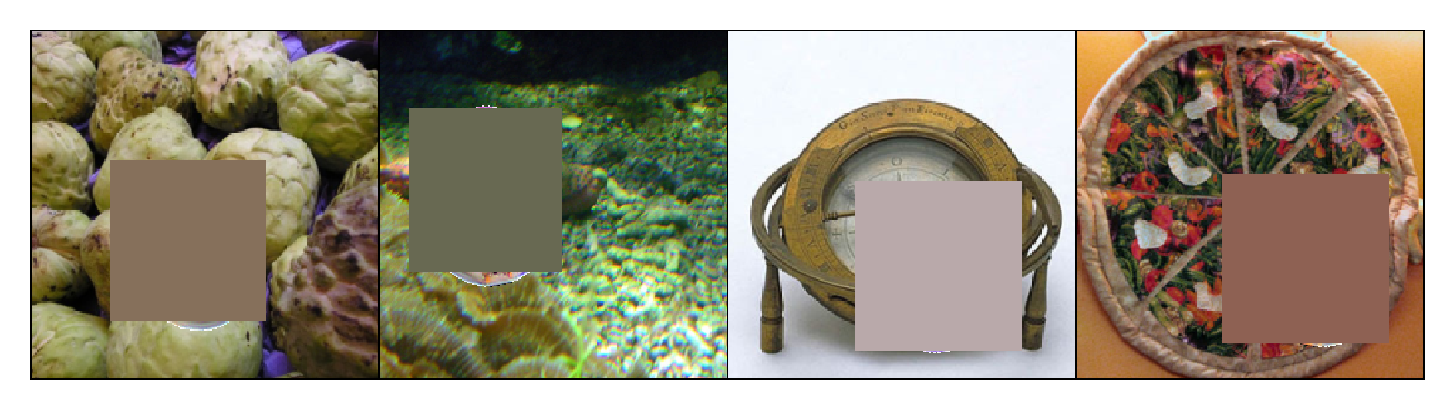

In [49]:
# imshow(data)
imshow(patched_data)
imshow(cleared_data)

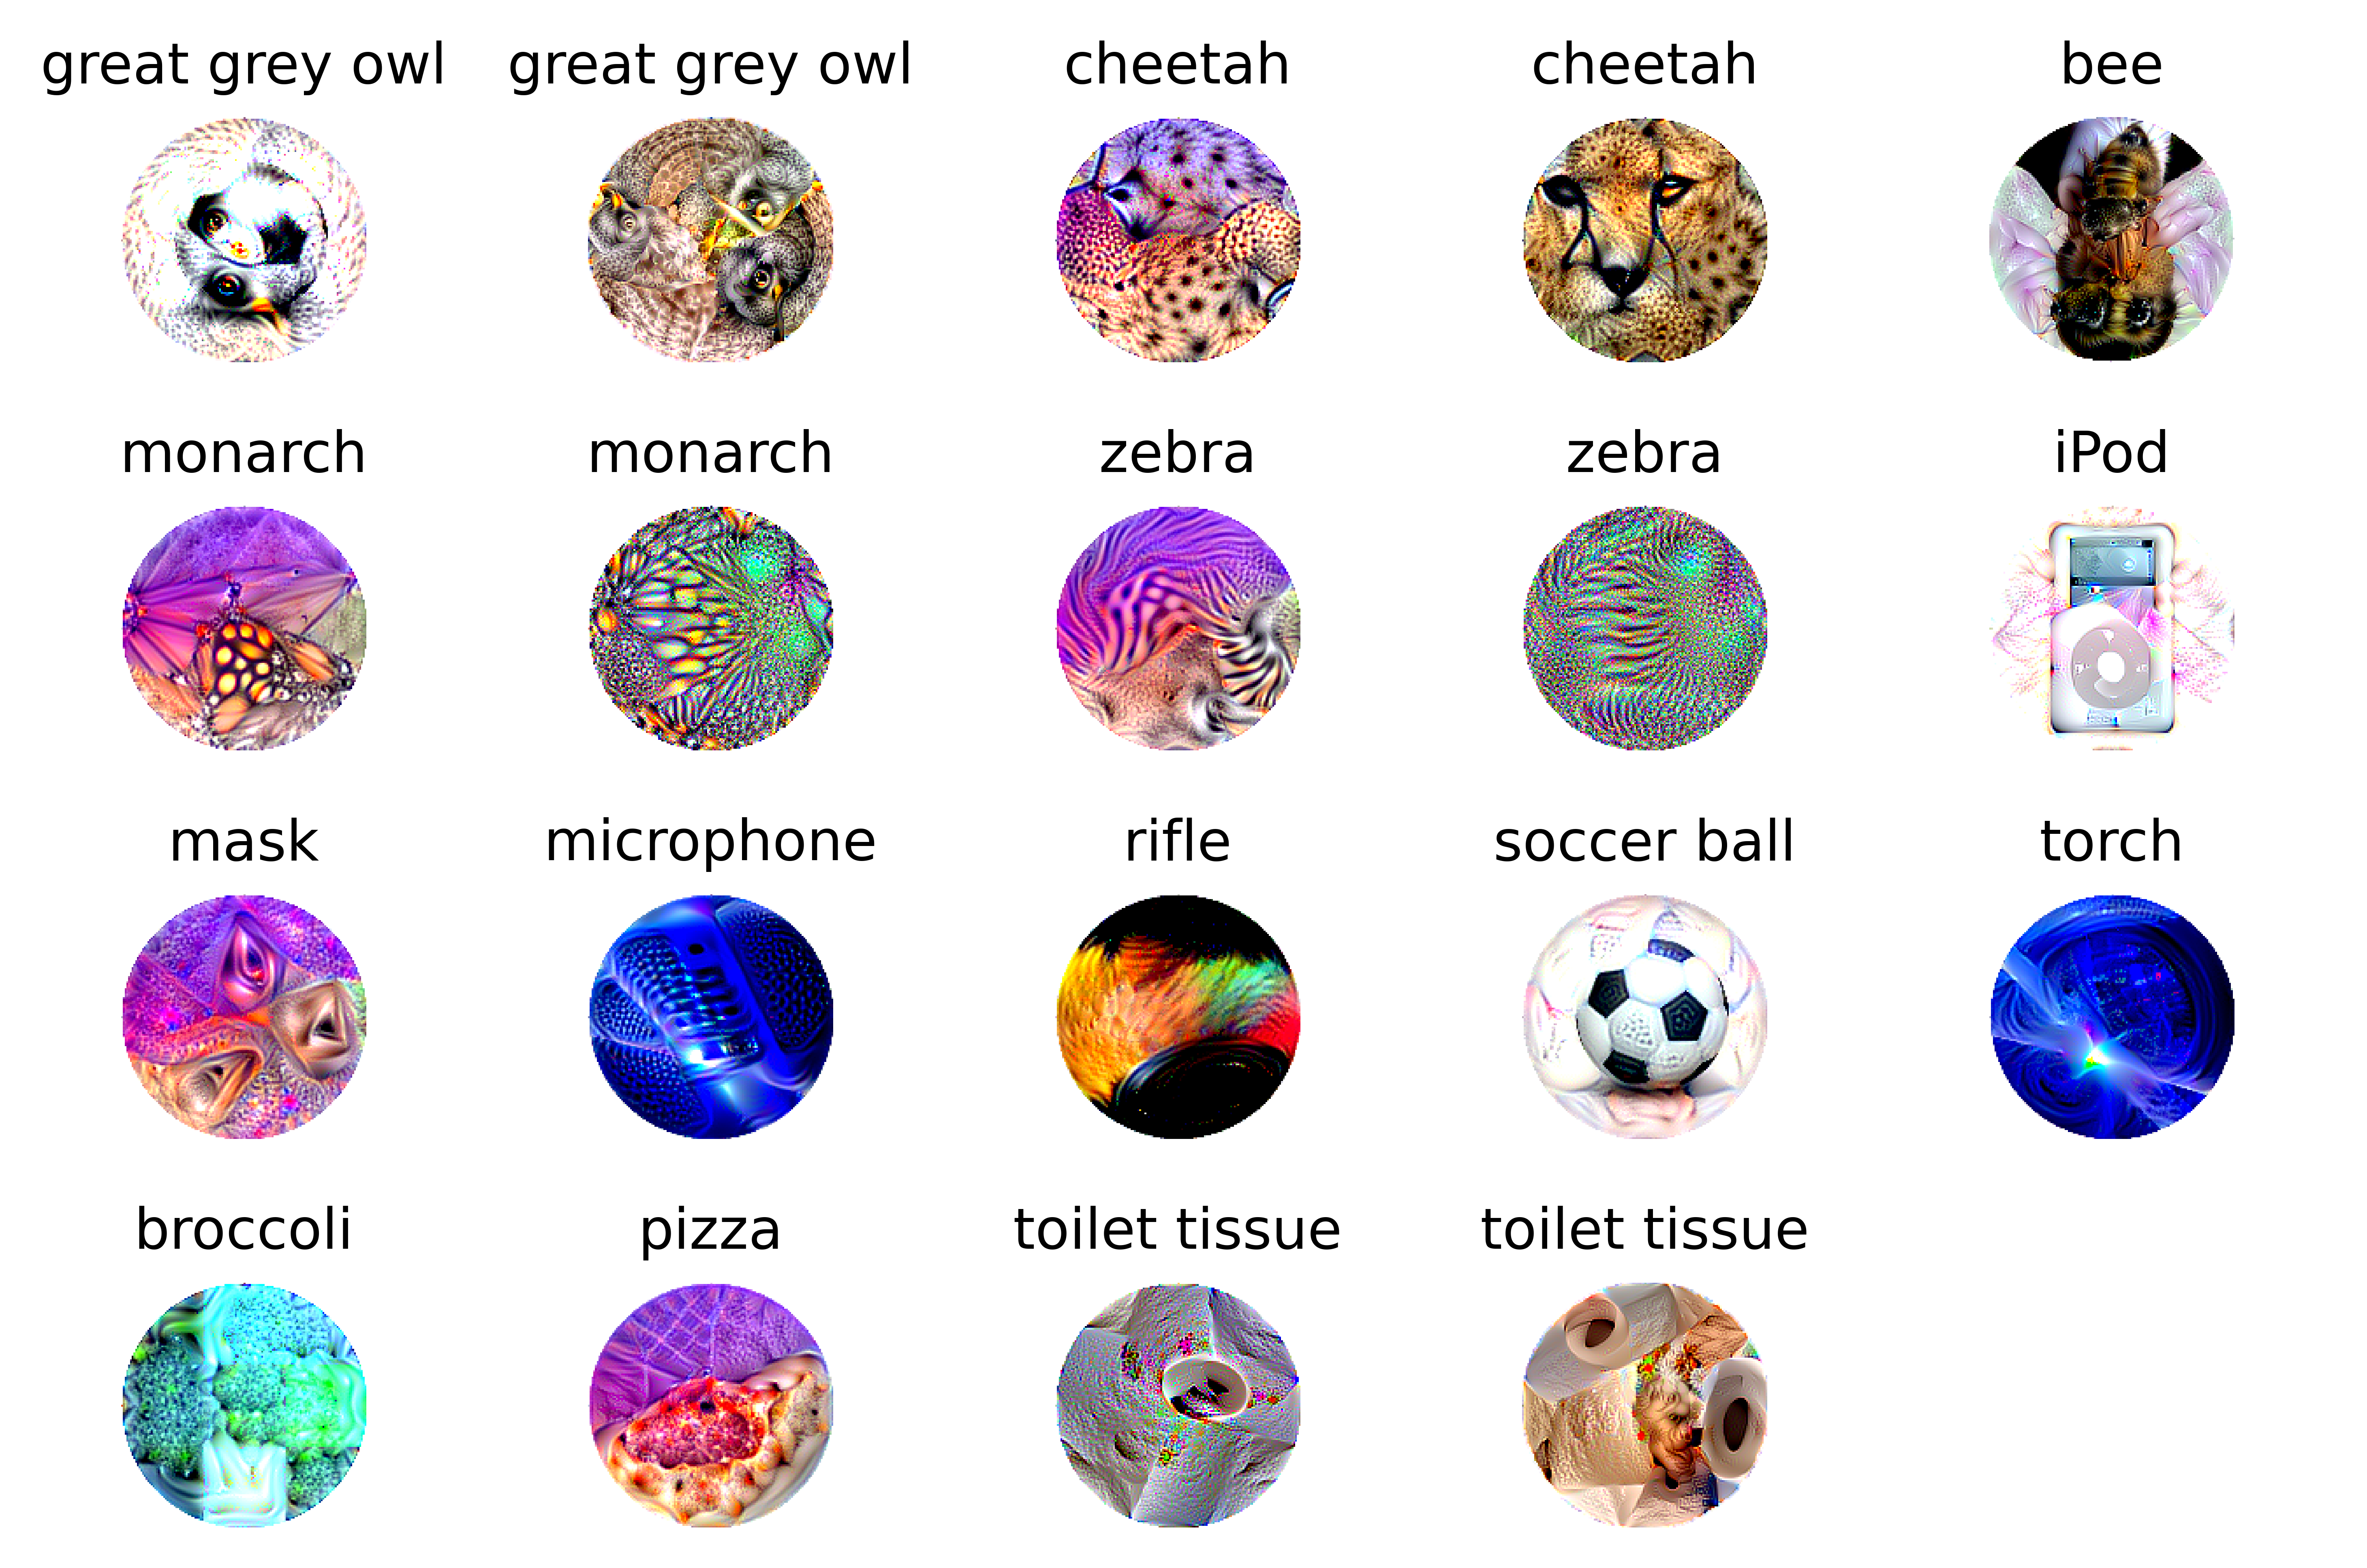

In [22]:
fig, ax = plt.subplots(4,5, squeeze=False, dpi=1000)
cur_i = 0
for a in ax:
    for x in a:
        if cur_i < len(patches):
            p = patches[cur_i]
            cl = dataset(244).classes[int(p.name.split('_')[0])][0]
            x.set_title(cl, {"fontsize": "10"})
            x.imshow(Image.open(p))
        x.axis('off')
        cur_i += 1
        
# ax[0,0].set_title('Init picture')
# ax[0,0].imshow(init)

fig.tight_layout()